# Financial Sentiment Analysis

**Importing libraries**

In [3]:
"""
https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
"""
import numpy as np # linear algebra
import pandas as pd # Used for data manipulation and analysis

# nltk imports
from nltk.tokenize import word_tokenize  #text is splitted into words in list
from nltk.corpus import stopwords  # this contains common stop words that has no effect in analysis
from nltk.stem import WordNetLemmatizer  #grouping together the different inflected forms of a word so they can be analyzed as a single item

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # bags of words and TF IDF
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer  # classification Metrics
from sklearn.naive_bayes import MultinomialNB  # Multiclassification
from sklearn.preprocessing import MinMaxScaler # scales the data to fit the range [0,1]
from sklearn import svm  # machine learning algorithm for classification
from sklearn.model_selection import StratifiedKFold  # For stratified splitting (helpful in imbalanced data)
from sklearn.preprocessing import LabelBinarizer  # for Categorical features
from sklearn.model_selection import GridSearchCV  # for tuning parameters
from sklearn.model_selection import train_test_split  # splitting dataset
from sklearn.ensemble import RandomForestClassifier #random forest classifier
from sklearn.svm import SVC #support vector classifier
from sklearn import metrics #accuracy measure
from sklearn import pipeline as Pipeline #pipeline
from sklearn import linear_model #linear model

import nltk
nltk.download('punkt') #for tokenization
nltk.download('averaged_perceptron_tagger')# perceptron tagger
nltk.download('stopwords') # for stop words

import re #regular expression

from gensim.models import KeyedVectors # for word2vec
!pip install gensim

import warnings # ignore warnings
warnings.simplefilter("ignore", UserWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\storm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\storm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\storm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Loading & Analyzing Data**

In [4]:
# reads the data
df=pd.read_csv("./data.csv")
#reads the first 5 rows
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
# shape of the data
df.shape

(5842, 2)

In [6]:
# checking the types of data
df.dtypes

Sentence     object
Sentiment    object
dtype: object

In [7]:
# checking for null values
df.isnull().sum()

Sentence     0
Sentiment    0
dtype: int64

In [8]:
# checking for unique values
df.Sentiment.unique()

array(['positive', 'negative', 'neutral'], dtype=object)

<AxesSubplot:>

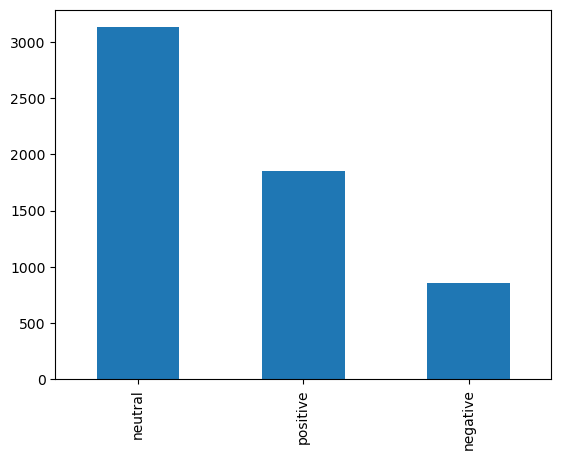

In [9]:
# checking for value counts
df.Sentiment.value_counts().plot.bar()

In [10]:
# mapping to the sentiment column 

dic = {'positive': 1, 'neutral': 0 , 'negative': -1}

df.Sentiment = df.Sentiment.map(dic)

In [11]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",-1
2,"For the last quarter of 2010 , Componenta 's n...",1
3,According to the Finnish-Russian Chamber of Co...,0
4,The Swedish buyout firm has sold its remaining...,0
...,...,...
5837,RISING costs have forced packaging producer Hu...,-1
5838,Nordic Walking was first used as a summer trai...,0
5839,"According shipping company Viking Line , the E...",0
5840,"In the building and home improvement trade , s...",0


**Model 1 NaiveBayes + BOW + Pipeline**

In [12]:
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # bag of words and TF IDF
from sklearn.model_selection import StratifiedKFold # for stratified splitting (helpful in imbalanced data)
from sklearn.metrics import precision_score, classification_report 
from sklearn import linear_model # linear model
from sklearn.naive_bayes import MultinomialNB # Multiclassification
from nltk.tokenize import word_tokenize # text is splitted into words in list
import numpy as np # linear algebra

# function to remove stopwords
def model(df, bow=False, TFIDF=False, model=linear_model.LogisticRegression(solver='liblinear')):

    kfoldnbr = 1 # Initiate kfold number

    df['kfold'] = -1  # Add a column to split data later
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle data and reset index

    # Initiate kfold
    np.random.seed(0)
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits)

    for f, (train, val) in enumerate(kf.split(X=df, y=df.Sentiment)):
        df.loc[val, 'kfold'] = f  # Assign each row to its validation set number

    if bow:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None) # Bag of words
    elif TFIDF:
        count_vec = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None) # TF IDF

#Pipeline to fit the model
    model_pipeline = Pipeline([
        ('vectorizer', count_vec),
        ('model', model)
    ])

# Loop through each fold
    for fold_, (train_idx, test_idx) in enumerate(kf.split(X=df, y=df.Sentiment)):
        train_df = df.loc[train_idx].reset_index(drop=True)# train data
        test_df = df.loc[test_idx].reset_index(drop=True) # test data

        model_instance = model()  # Instantiate the model inside the loop
        model_pipeline.set_params(model=model_instance) # Set the model inside the pipeline
        model_pipeline.fit(train_df.Sentence, train_df.Sentiment) # Fit the model
        preds = model_pipeline.predict(test_df.Sentence) # Predict the model
        accuracy_precision = precision_score(test_df.Sentiment, preds, average='macro') # Calculate precision score
        print('fold:', kfoldnbr) # Print the fold number
        kfoldnbr += 1 # Increment the fold number
        print('precision score:', accuracy_precision)

    print(classification_report(test_df.Sentiment, preds))

model(df, bow=True, model=MultinomialNB)  # Remove the parentheses after MultinomialNB

fold: 1
precision score: 0.6130066651902086
fold: 2
precision score: 0.6192805510176725
fold: 3
precision score: 0.6401880170115347
fold: 4
precision score: 0.6253871627672657
fold: 5
precision score: 0.6190515958438502
              precision    recall  f1-score   support

          -1       0.43      0.29      0.35       172
           0       0.72      0.83      0.77       626
           1       0.70      0.62      0.66       370

    accuracy                           0.69      1168
   macro avg       0.62      0.58      0.59      1168
weighted avg       0.67      0.69      0.67      1168



**Model-2 Naive Bayes with TFIDF**

In [13]:
# Now lets try with TF-IDF vectorizer instead of bag of words to MultinomialNB().

model(df, TFIDF=True, model= MultinomialNB)

fold: 1
precision score: 0.7552450242317182
fold: 2
precision score: 0.7965176893969463
fold: 3
precision score: 0.7733023622594174
fold: 4
precision score: 0.6716033584069416
fold: 5
precision score: 0.6935910120550942
              precision    recall  f1-score   support

          -1       0.75      0.02      0.03       172
           0       0.64      0.98      0.77       626
           1       0.69      0.37      0.49       370

    accuracy                           0.65      1168
   macro avg       0.69      0.46      0.43      1168
weighted avg       0.67      0.65      0.57      1168



**Processing text**

In [14]:
# Now lets do some cleaning on the text data and apply it to baseline model and compare the accuracies.
stop_words = [i for i in stopwords.words('english') if "n't" not in i and i not in ('not','no')]

def process_text(text):
    
    text = word_tokenize(text) # tokenize words in text
    text = [re.sub('[^A-Za-z]+', '', word) for word in text] # this line substitutes any white space before the word by removing the space
    text = [word.lower() for word in text if word.isalpha()] # lower each word in text
    text = [word for word in text if word not in stop_words]
    text = [WordNetLemmatizer().lemmatize(word) for word in text] # lemmatization of words
    text = ' '.join(text) # join words into text again
    return text

In [15]:
#Testing the tokenizer
text = 'He is not a good person'
token_text = word_tokenize(text) # tokenize words in text
[ word for word in token_text if word not in stop_words] # remove stop words

['He', 'not', 'good', 'person']

In [16]:
df.Sentence = df.Sentence.apply(process_text) # this line applies process_text function to Sentence in dataset
df.Sentence

0       geosolutions technology leverage benefon gps s...
1                             esi low bk real possibility
2       last quarter componenta net sale doubled eurm ...
3       according finnishrussian chamber commerce majo...
4       swedish buyout firm sold remaining percent sta...
                              ...                        
5837    rising cost forced packaging producer huhtamak...
5838    nordic walking first used summer training meth...
5839    according shipping company viking line eu deci...
5840    building home improvement trade sale decreased...
5841    helsinki afx kci konecranes said order four ho...
Name: Sentence, Length: 5842, dtype: object

In [17]:
# Import package
import matplotlib.pyplot as plt
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [18]:
!pip install wordcloud # install wordcloud package

ERROR: Invalid requirement: '#'


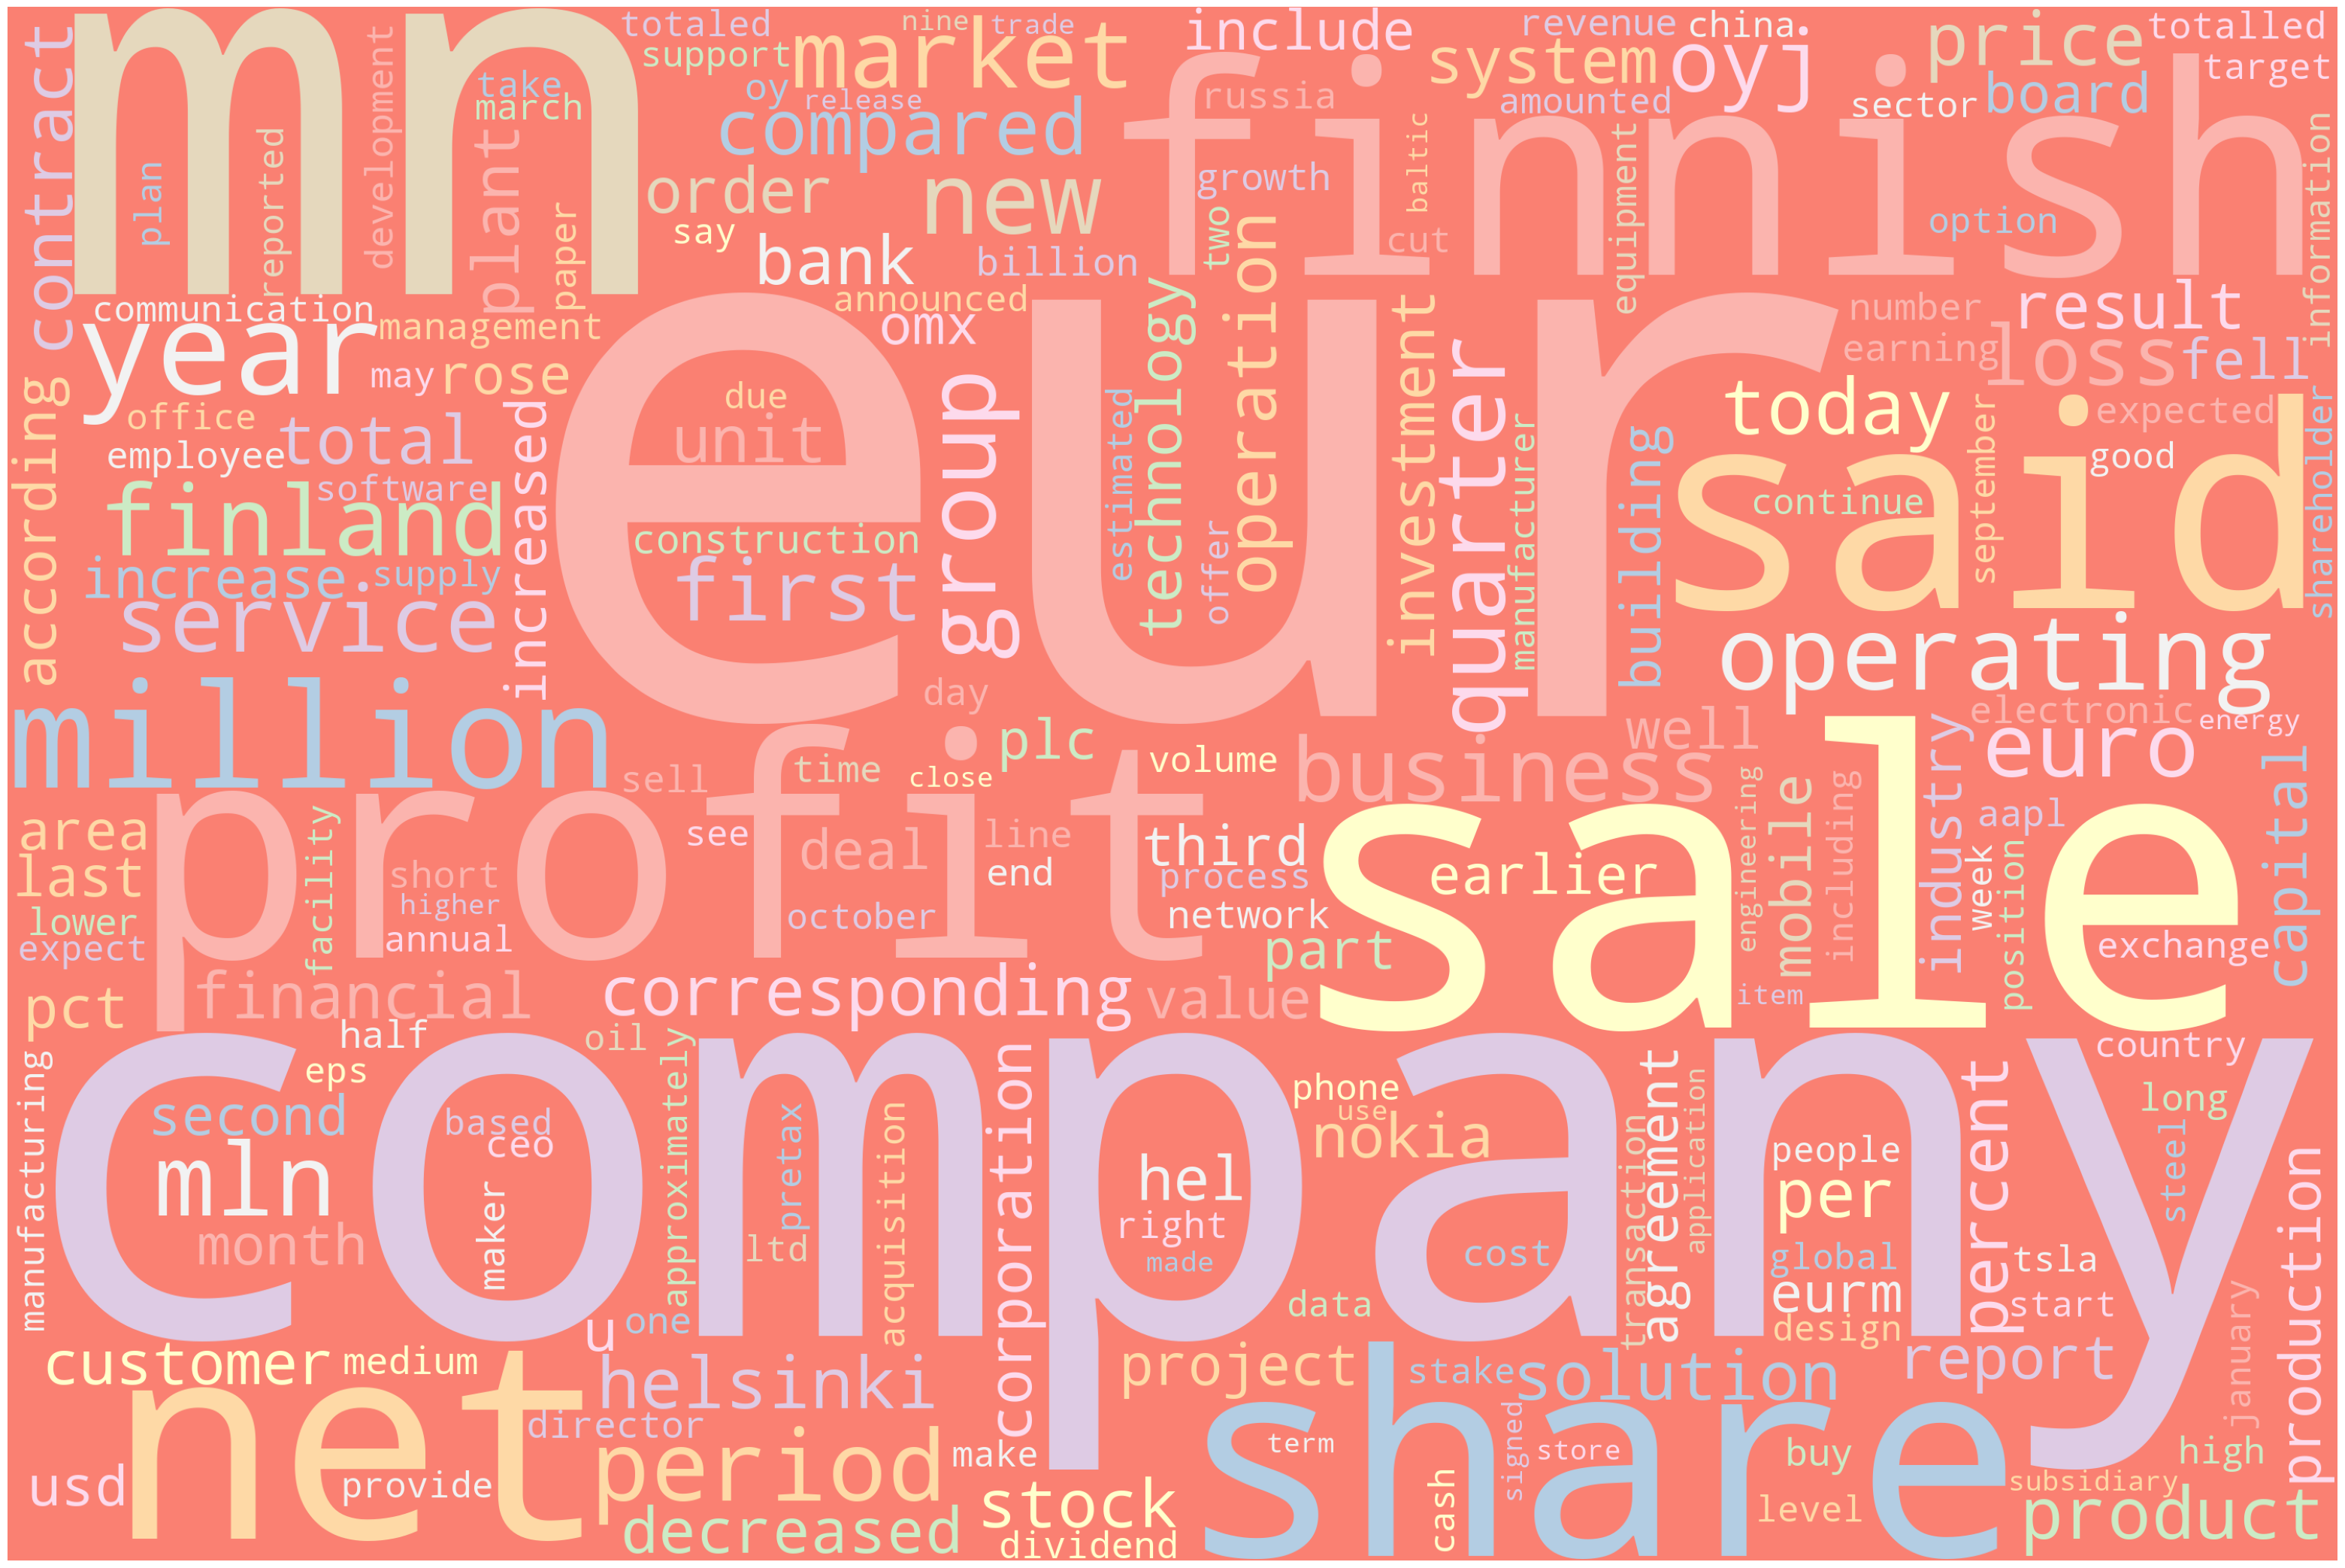

In [19]:
# Import package
from wordcloud import WordCloud

# Extract text from DataFrame column
text = df['Sentence'].str.cat(sep=' ')

# Generate word cloud
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False).generate(text)
# Plot
plot_cloud(wordcloud)

**LDA model**

In [20]:
#Training an LDA model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer() # Instantiate the vectorizer
X = vectorizer.fit_transform(df['Sentence']) # Fit the vectorizer to the data

lda = LatentDirichletAllocation(n_components=10)  # Specify the number of topics
lda.fit(X)

feature_names = vectorizer.get_feature_names_out()  # Get the feature names (words)
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    top_words_indices = topic.argsort()[:-10 - 1:-1]  # Get the indices of the top 10 words
    top_words = feature_names[top_words_indices]
    print(top_words)

Topic #0:
['system' 'contract' 'new' 'finland' 'manufacturer' 'technology' 'company'
 'finnish' 'scanfil' 'plant']
Topic #1:
['eur' 'mn' 'profit' 'sale' 'operating' 'net' 'period' 'quarter' 'million'
 'loss']
Topic #2:
['company' 'see' 'said' 'today' 'may' 'change' 'expected' 'project'
 'return' 'chairman']
Topic #3:
['finland' 'company' 'group' 'market' 'value' 'investment' 'bank' 'said'
 'percent' 'plc']
Topic #4:
['million' 'said' 'finnish' 'company' 'net' 'eur' 'year' 'oyj' 'hel'
 'profit']
Topic #5:
['http' 'aapl' 'not' 'long' 'tsla' 'short' 'price' 'stock' 'company' 'buy']
Topic #6:
['mln' 'euro' 'finnish' 'helsinki' 'company' 'pct' 'omx' 'said' 'oyj'
 'share']
Topic #7:
['company' 'business' 'operation' 'area' 'customer' 'finland' 'price'
 'new' 'also' 'share']
Topic #8:
['share' 'company' 'market' 'stock' 'right' 'option' 'board' 'capital'
 'corporation' 'dividend']
Topic #9:
['service' 'company' 'product' 'business' 'also' 'mobile' 'market' 'data'
 'network' 'customer']


**Model-3 Cleaned Naive Bayes + BOW**

In [21]:
#Testing the processed text with the models
model(df,bow = True,model = MultinomialNB)

fold: 1
precision score: 0.6166355310967316
fold: 2
precision score: 0.6177821588484614
fold: 3
precision score: 0.6083381646360443
fold: 4
precision score: 0.6146799614399697
fold: 5
precision score: 0.5926863446054385
              precision    recall  f1-score   support

          -1       0.35      0.32      0.33       172
           0       0.74      0.77      0.76       626
           1       0.69      0.67      0.68       370

    accuracy                           0.67      1168
   macro avg       0.59      0.59      0.59      1168
weighted avg       0.67      0.67      0.67      1168



**Glove vectors with our model**

In [22]:
class Word2VecVectorizer:
    
    
    def __init__(self, word_vectors):
        print("Loading in word vectors...")
        self.word_vectors = word_vectors # word2vec model
        print("Finished loading in word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # Determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king') # get vector of word king
        self.D = v.shape[0] # get the shape of the vector

        X = np.zeros((len(data), self.D)) # create a matrix of zeros with the shape of the data and the dimensionality of the vector
        n = 0
        empty_count = 0

        for sentence in data:
            tokens = sentence.split() # split the sentence into words
            vecs = []
            m = 0

            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word) # get the vector of each word
                    vecs.append(vec) # append the vector to the list
                    m += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs) # convert the list to an array
                X[n] = vecs.mean(axis=0) # get the mean of the vectors
            else:
                empty_count += 1

            n += 1

        print("Number of samples with no words found: %s / %s" % (empty_count, len(data))) # print the number of samples with no words found
        return X

    def fit_transform(self, data): # fit and transform the data
        self.fit(data)
        return self.transform(data)

In [23]:
word2vec_output_file = './glove_w2v.txt' # path to the word2vec file
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False) # load the word2vec file
Xtrain,Xtest,ytrain,ytest = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2, # split the data into train and test sets
random_state = 42,stratify =df.Sentiment )

In [24]:
#we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. 
#Then we can use those vectors to feed our classifier.

vectorizer = Word2VecVectorizer(word_vectors)

X_train = vectorizer.fit_transform(Xtrain)
y_train = ytrain

X_test = vectorizer.transform(Xtest)
y_test = ytest

Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 4673
Number of samples with no words found: 0 / 1169


In [25]:
# Define the parameters to tune
parameters = {
    'C': [0.5, 1.0, 3],
    'gamma': [1, 'auto', 'scale'],
    'kernel': ['rbf','linear']
}

model = GridSearchCV(SVC(), parameters, cv=5, n_jobs=-1,verbose=1) # Instantiate the grid search

model.fit(X_train,y_train) # Fit the grid search

y_pred = model.predict(X_test) # Predict the model

print(classification_report(y_test,y_pred)) # Print the classification report
print(model.best_params_) # Print the best parameters

Fitting 5 folds for each of 18 candidates, totalling 90 fits
              precision    recall  f1-score   support

          -1       0.54      0.20      0.29       172
           0       0.70      0.89      0.78       626
           1       0.70      0.58      0.64       371

    accuracy                           0.69      1169
   macro avg       0.65      0.56      0.57      1169
weighted avg       0.68      0.69      0.66      1169

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


**This is our best performing model, we will use it to predict the sentiment of inputted text**

In [26]:
input_text = input() # Get the input text from the user

In [27]:
""""
Predict the sentiment of the input text
"""
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from gensim.models import KeyedVectors
import numpy as np

# class to apply vectorization to the inputted text
class Word2VecVectorizer:
    def __init__(self, word_vectors):
        print("Loading word vectors...")
        self.word_vectors = word_vectors
        print("Finished loading word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        empty_count = 0

        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0

            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                empty_count += 1

            n += 1

        print("Number of samples with no words found: %s / %s" % (empty_count, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

word2vec_output_file = './glove_w2v.txt'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#process_text() to preprocess users inputted text
preprocessed_text = process_text(input_text)

#DataFrame with the preprocessed text
df_input = pd.DataFrame({'text': [preprocessed_text]})

#training data X_train and labels y_train
# train the model using GridSearchCV
parameters = {
    'C': [0.5, 1.0, 3],
    'gamma': [1, 'auto', 'scale'],
    'kernel': ['rbf', 'linear']
}
model = GridSearchCV(SVC(), parameters, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

#test data X_test and labels y_test
# make predictions on the vectorized input text
X_input = vectorizer.transform(df_input['text'])
y_pred = model.predict(X_input)

# Print the prediction
print("Prediction:")
if y_pred == 1:
    print("Positive")
elif y_pred == 0:
    print("Neutral")
elif y_pred == -1:
    print("Negative")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Number of samples with no words found: 0 / 1
Prediction:
Neutral


**Model-3 tuned + Pipeline**

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize

def scoring(y_train, y_pred): # function to calculate the f1 score
    return f1_score(y_train, y_pred, average='macro') # return the f1 score

# Model 5 Tuning - Naive Bayes
count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None) # CountVectorizer
model_nb = MultinomialNB() # Naive Bayes

pipeline_nb = Pipeline([ # Pipeline
    ('vectorizer', count_vec),
    ('model', model_nb)
])

parameters_nb = {'model__alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 1.6, 1.8, 10, 100]} # Parameters

grid_search_nb = GridSearchCV(pipeline_nb, parameters_nb, cv=5, scoring=make_scorer(scoring), n_jobs=-1, verbose=1) # GridSearchCV
grid_result_nb = grid_search_nb.fit(df.Sentence, df.Sentiment) # Fit the grid search

print('Best params (Naive Bayes): ', grid_result_nb.best_params_)
print('Best score (Naive Bayes): ', grid_result_nb.best_score_)

# SVM Hyperparameter Tuning
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

count_vec_svm = CountVectorizer(tokenizer=word_tokenize, token_pattern=None) # CountVectorizer
model_svm = SVC() # SVM

pipeline_svm = Pipeline([ # Pipeline
    ('vectorizer', count_vec_svm),
    ('model', model_svm)
])

param_grid_svm = { # Parameters
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': [1, 0.1, 0.01, 0.001],
    'model__kernel': ['rbf', 'linear']
}

grid_search_svm = GridSearchCV(pipeline_svm, param_grid_svm, refit=True, verbose=1, cv=5, scoring=make_scorer(scoring), n_jobs=-1) # GridSearchCV
grid_result_svm = grid_search_svm.fit(df.Sentence, df.Sentiment) # Fit the grid search

print('Best params (SVM): ', grid_result_svm.best_params_) # Print the best parameters
print('Best score (SVM): ', grid_result_svm.best_score_) # Print the best score

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best params (Naive Bayes):  {'model__alpha': 0.7}
Best score (Naive Bayes):  0.6097151026504848
Fitting 5 folds for each of 32 candidates, totalling 160 fits
